In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
from numpy import dstack
from pandas import read_csv
 
# load a single file as a numpy array
def load_file(filepath):
 dataframe = read_csv(filepath, header=None, delim_whitespace=True)
 return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
 loaded = list()
 for name in filenames:
  data = load_file(prefix + name)
  loaded.append(data)
 # stack group so that features are the 3rd dimension
 loaded = dstack(loaded)
 return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
 filepath = prefix + group + '/Inertial Signals/'
 # load all 9 files as a single array
 filenames = list()
 # total acceleration
 filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
 # body acceleration
 filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
 # body gyroscope
 filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
 # load input data
 X = load_group(filenames, filepath)
 # load class output
 y = load_file(prefix + group + '/y_'+group+'.txt')
 return X, y
 
# load all train
trainX, trainy = load_dataset('train', '/content/drive/My Drive/datasets/UCI HAR Dataset/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', '/content/drive/My Drive/datasets/UCI HAR Dataset/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [4]:
import tensorflow as tf
trainy = trainy - 1
testy = testy - 1
trainy = tf.keras.utils.to_categorical(trainy)
testy = tf.keras.utils.to_categorical(testy)

CNN

In [5]:
from tensorflow import keras
from keras.layers import Conv1D,Dropout,MaxPooling1D,Flatten,Dense

cnn_model = keras.Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(128,9)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))
cnn_model.summary()
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 128)          3584      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 128)           0         
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 100)               806500    
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                        

In [6]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
cnn_output = cnn_model.fit(
  x=trainX, 
  y=trainy, 
  epochs=20,
  batch_size = 128,
  validation_data = (testX,testy),
  callbacks = [early_stop]
)

Epoch 1/20
58/58 [==============================] - 6s 83ms/step - loss: 0.5575 - accuracy: 0.7685 - val_loss: 0.5692 - val_accuracy: 0.7937
Epoch 2/20
58/58 [==============================] - 5s 87ms/step - loss: 0.2435 - accuracy: 0.9117 - val_loss: 0.4453 - val_accuracy: 0.8643
Epoch 3/20
58/58 [==============================] - 5s 94ms/step - loss: 0.1766 - accuracy: 0.9336 - val_loss: 0.3908 - val_accuracy: 0.8880
Epoch 4/20
58/58 [==============================] - 4s 77ms/step - loss: 0.1393 - accuracy: 0.9464 - val_loss: 0.4126 - val_accuracy: 0.8765
Epoch 5/20
58/58 [==============================] - 5s 87ms/step - loss: 0.1258 - accuracy: 0.9487 - val_loss: 0.3613 - val_accuracy: 0.8918
Epoch 6/20
58/58 [==============================] - 5s 90ms/step - loss: 0.1130 - accuracy: 0.9533 - val_loss: 0.3586 - val_accuracy: 0.8911
Epoch 7/20
58/58 [==============================] - 4s 72ms/step - loss: 0.1110 - accuracy: 0.9518 - val_loss: 0.4001 - val_accuracy: 0.8955
Epoch 8/20
58

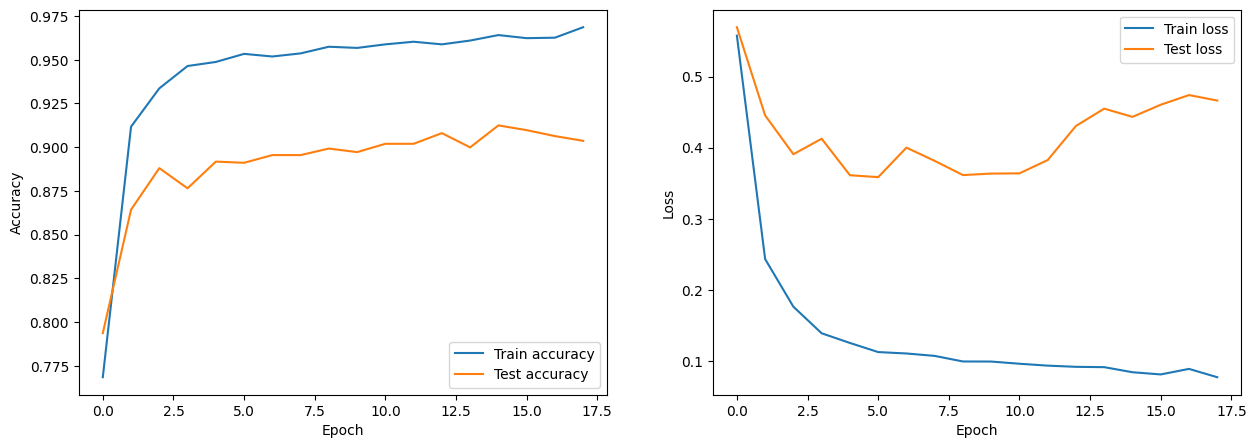

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(cnn_output.history['accuracy'], label='accuracy')
plt.plot(cnn_output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(cnn_output.history['loss'], label='loss')
plt.plot(cnn_output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Test loss'], loc='upper right')

In [8]:
import numpy as np
def recogniseActivity(l):
  labelIndex = np.argmax(l)
  l[:]=0
  for i in range(6):
    if i==labelIndex:
      l[i]=1
  return l

testList = [0,7,16,29,36,42,50,65,73,86,94,100,151,628,757,921,1000,1311,1954,2231,2569,2946]
for i in testList:
  y_pred = recogniseActivity(cnn_model.predict(np.expand_dims(testX[i], axis=0))[0])
  print(y_pred,testy[i])

1/1 [==============================] - 0s 116ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 37ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 41ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 39ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 34ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 35ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 49ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 39ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 

In [9]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from keras.utils import to_categorical

y_pred = cnn_model.predict(testX)
pred_labels = to_categorical(np.argmax(y_pred, axis=1))
cnn_acc = accuracy_score(testy,pred_labels)
print(cnn_acc)
print(precision_score(testy,pred_labels,average='weighted'))
print(recall_score(testy,pred_labels,average='weighted'))


93/93 [==============================] - 1s 6ms/step
0.9036308109942314
0.9091241609388144
0.9036308109942314


93/93 [==============================] - 1s 6ms/step


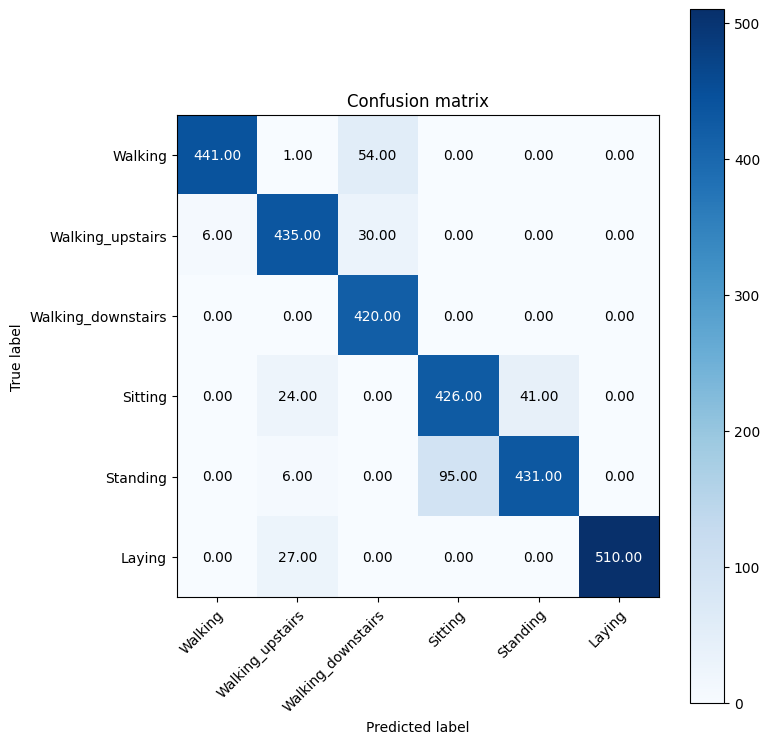

In [10]:
from sklearn.metrics import confusion_matrix

# Assuming you have predicted labels in a numpy array called pred_labels 
# and ground truth labels in another numpy array called true_labels

# Compute confusion matrix

cm = confusion_matrix(np.argmax(testy, axis=1), np.argmax(to_categorical(np.argmax(cnn_model.predict(testX), axis=1)),axis=1))

# Define class names (assuming you have 6 classes)
class_names = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f'  # set format for decimal places
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [11]:
import time
start_time_testing = time.time()
cnn_model.evaluate(testX, testy)
end_time_testing = time.time()
cnn_time = end_time_testing-start_time_testing

93/93 [==============================] - 1s 10ms/step - loss: 0.4663 - accuracy: 0.9036


LSTM

In [12]:
timesteps = 128
input_dim = 9
output_dim = 6

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(output_dim, activation='softmax')
])

lstm_model.summary()
lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           18944     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)

lstm_output = lstm_model.fit(
  x=trainX, 
  y=trainy, 
  epochs=20,
  batch_size = 128,
  validation_data = (testX,testy),
  callbacks = [early_stop]
)

Epoch 1/20
58/58 [==============================] - 38s 584ms/step - loss: 1.2107 - accuracy: 0.4890 - val_loss: 1.0385 - val_accuracy: 0.5626
Epoch 2/20
58/58 [==============================] - 33s 571ms/step - loss: 0.7263 - accuracy: 0.6884 - val_loss: 0.6710 - val_accuracy: 0.7346
Epoch 3/20
58/58 [==============================] - 38s 654ms/step - loss: 0.6509 - accuracy: 0.7397 - val_loss: 0.6663 - val_accuracy: 0.7326
Epoch 4/20
58/58 [==============================] - 33s 572ms/step - loss: 0.4351 - accuracy: 0.8345 - val_loss: 0.5102 - val_accuracy: 0.8293
Epoch 5/20
58/58 [==============================] - 33s 569ms/step - loss: 0.3373 - accuracy: 0.8779 - val_loss: 0.5065 - val_accuracy: 0.8351
Epoch 6/20
58/58 [==============================] - 32s 556ms/step - loss: 0.2273 - accuracy: 0.9223 - val_loss: 0.4350 - val_accuracy: 0.8619
Epoch 7/20
58/58 [==============================] - 37s 638ms/step - loss: 0.1837 - accuracy: 0.9384 - val_loss: 0.4155 - val_accuracy: 0.8782

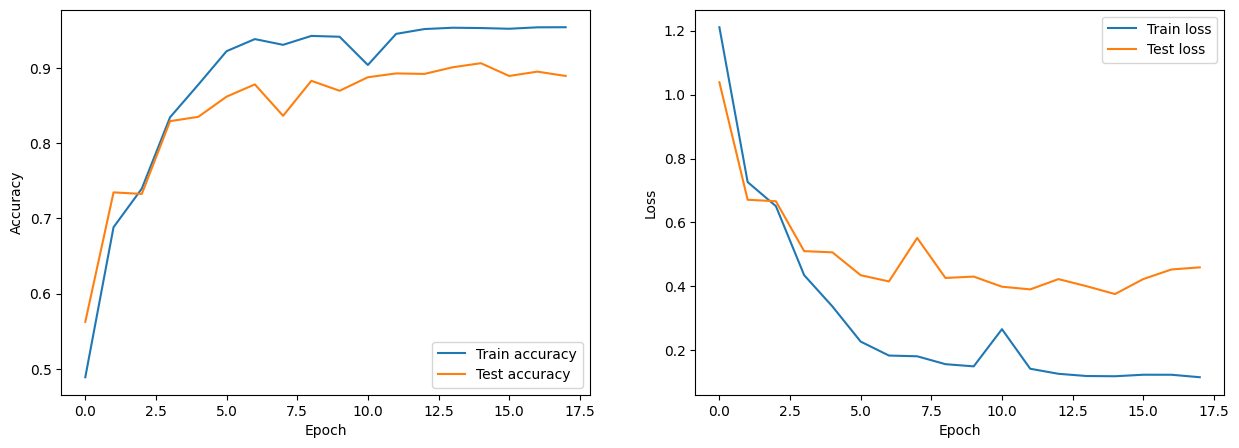

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(lstm_output.history['accuracy'], label='accuracy')
plt.plot(lstm_output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(lstm_output.history['loss'], label='loss')
plt.plot(lstm_output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Test loss'], loc='upper right')

In [15]:
import numpy as np
def recogniseActivity(l):
  labelIndex = np.argmax(l)
  l[:]=0
  for i in range(6):
    if i==labelIndex:
      l[i]=1
  return l

testList = [0,7,16,29,36,42,50,65,73,86,94,100,151,628,757,921,1000,1311,1954,2231,2569,2946]
for i in testList:
  y_pred = recogniseActivity(lstm_model.predict(np.expand_dims(testX[i], axis=0))[0])
  print(y_pred,testy[i])

1/1 [==============================] - 1s 850ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 34ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 35ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 65ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 70ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 59ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 56ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 67ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 55ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 58ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 79ms/step
[0. 1. 0. 0. 0. 0.] [1. 0. 

In [16]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from keras.utils import to_categorical

y_pred = lstm_model.predict(testX)
pred_labels = to_categorical(np.argmax(y_pred, axis=1))
lstm_acc = accuracy_score(testy,pred_labels)
print(lstm_acc)
print(precision_score(testy,pred_labels,average='weighted'))
print(recall_score(testy,pred_labels,average='weighted'))


93/93 [==============================] - 6s 59ms/step
0.8893790295215473
0.8925200987516775
0.8893790295215473


93/93 [==============================] - 5s 53ms/step


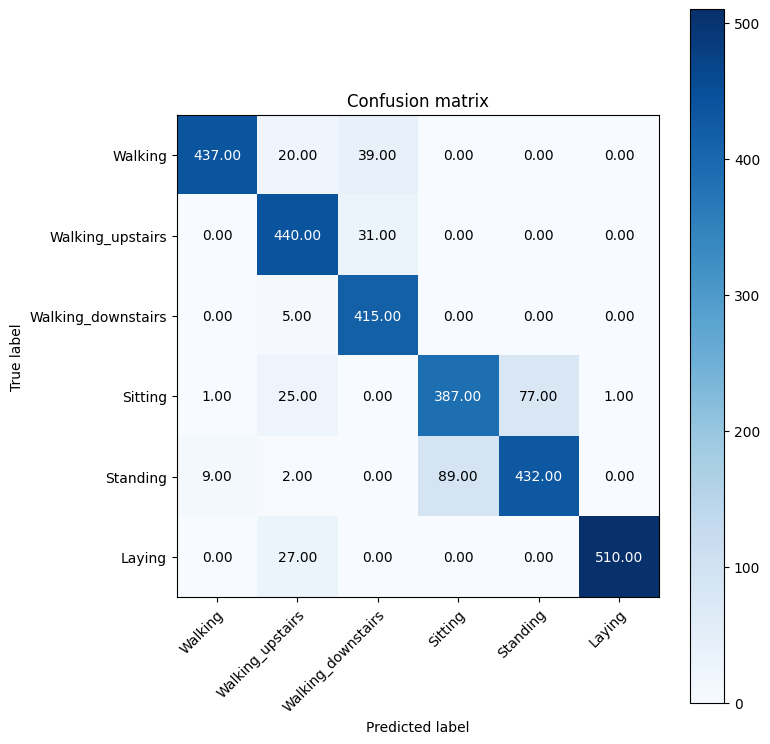

In [17]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix

cm = confusion_matrix(np.argmax(testy, axis=1), np.argmax(to_categorical(np.argmax(lstm_model.predict(testX), axis=1)),axis=1))

# Define class names (6 classes)
class_names = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f'  # set format for decimal places
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [18]:
import time
start_time_testing = time.time()
lstm_model.evaluate(testX, testy)
end_time_testing = time.time()
lstm_time = end_time_testing-start_time_testing

93/93 [==============================] - 4s 40ms/step - loss: 0.4595 - accuracy: 0.8894


CNN-LSTM

In [19]:
from keras.layers import Reshape,LSTM

cnnlstm_model = keras.Sequential()

# Add the convolutional layers
cnnlstm_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(128,9)))
cnnlstm_model.add(MaxPooling1D(pool_size=2))
cnnlstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnnlstm_model.add(MaxPooling1D(pool_size=2))

# Flatten the output of the convolutional layers
cnnlstm_model.add(Flatten())

# Add the LSTM layer
cnnlstm_model.add(Reshape((64,-1))),
cnnlstm_model.add(LSTM(64, return_sequences=False))
cnnlstm_model.add(Dense(100, activation='relu'))
cnnlstm_model.add(Dense(6, activation='softmax'))
cnnlstm_model.summary()
cnnlstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 128)          3584      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 63, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 61, 64)            24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 reshape (Reshape)           (None, 64, 30)           

In [20]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)

cnnlstm_output = cnnlstm_model.fit(
  x=trainX, 
  y=trainy, 
  epochs=20,
  batch_size = 128,
  validation_data = (testX,testy),
  callbacks = [early_stop]
)

Epoch 1/20
58/58 [==============================] - 18s 254ms/step - loss: 1.1443 - accuracy: 0.5351 - val_loss: 1.0128 - val_accuracy: 0.5646
Epoch 2/20
58/58 [==============================] - 14s 238ms/step - loss: 0.6059 - accuracy: 0.7223 - val_loss: 0.6491 - val_accuracy: 0.7323
Epoch 3/20
58/58 [==============================] - 18s 312ms/step - loss: 0.4275 - accuracy: 0.8181 - val_loss: 0.5794 - val_accuracy: 0.7587
Epoch 4/20
58/58 [==============================] - 14s 234ms/step - loss: 0.3104 - accuracy: 0.8766 - val_loss: 0.5090 - val_accuracy: 0.8137
Epoch 5/20
58/58 [==============================] - 14s 235ms/step - loss: 0.2507 - accuracy: 0.9029 - val_loss: 0.5566 - val_accuracy: 0.7910
Epoch 6/20
58/58 [==============================] - 13s 216ms/step - loss: 0.1942 - accuracy: 0.9257 - val_loss: 0.5306 - val_accuracy: 0.8378
Epoch 7/20
58/58 [==============================] - 12s 207ms/step - loss: 0.1671 - accuracy: 0.9336 - val_loss: 0.4152 - val_accuracy: 0.8582

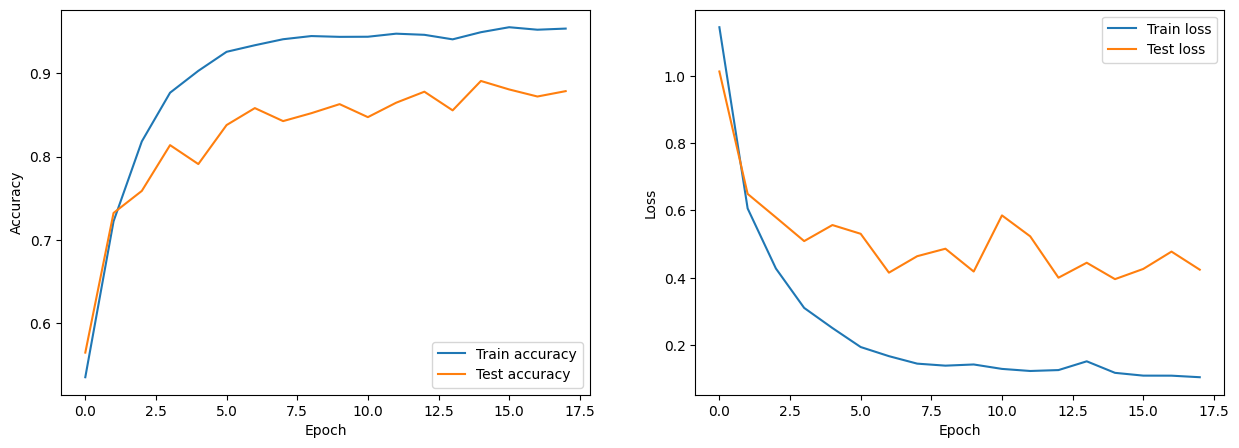

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(cnnlstm_output.history['accuracy'], label='accuracy')
plt.plot(cnnlstm_output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(cnnlstm_output.history['loss'], label='loss')
plt.plot(cnnlstm_output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Test loss'], loc='upper right')

In [22]:
import numpy as np
def recogniseActivity(l):
  labelIndex = np.argmax(l)
  l[:]=0
  for i in range(6):
    if i==labelIndex:
      l[i]=1
  return l

testList = [0,7,16,29,36,42,50,65,73,86,94,100,151,628,757,921,1000,1311,1954,2231,2569,2946]
for i in testList:
  y_pred = recogniseActivity(cnnlstm_model.predict(np.expand_dims(testX[i], axis=0))[0])
  print(y_pred,testy[i])

1/1 [==============================] - 1s 530ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 27ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 29ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 28ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 36ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 28ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 30ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 29ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 27ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 

In [23]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from keras.utils import to_categorical

y_pred = cnnlstm_model.predict(testX)
pred_labels = to_categorical(np.argmax(y_pred, axis=1))
cnnlstm_acc = accuracy_score(testy,pred_labels)
print(cnnlstm_acc)
print(precision_score(testy,pred_labels,average='weighted'))
print(recall_score(testy,pred_labels,average='weighted'))


93/93 [==============================] - 3s 31ms/step
0.8785205293518833
0.8793561823575786
0.8785205293518833


93/93 [==============================] - 2s 21ms/step


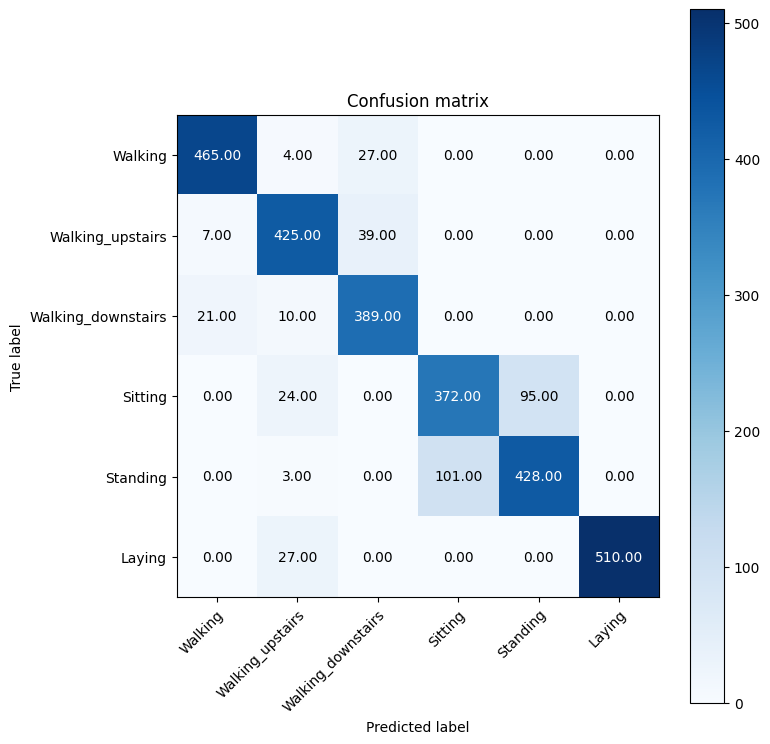

In [24]:
from sklearn.metrics import confusion_matrix

# Assuming you have predicted labels in a numpy array called pred_labels 
# and ground truth labels in another numpy array called true_labels

# Compute confusion matrix

cm = confusion_matrix(np.argmax(testy, axis=1), np.argmax(to_categorical(np.argmax(cnnlstm_model.predict(testX), axis=1)),axis=1))

# Define class names (assuming you have 6 classes)
class_names = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f'  # set format for decimal places
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [25]:
import time
start_time_testing = time.time()
cnnlstm_model.evaluate(testX, testy)
end_time_testing = time.time()
cnnlstm_time = end_time_testing-start_time_testing

93/93 [==============================] - 2s 18ms/step - loss: 0.4240 - accuracy: 0.8785


ConvAE

In [26]:
cae_model = tf.keras.Sequential([
    
tf.keras.layers.Conv1D(64, 3, activation='relu', padding = 'Same', input_shape=(128, 9)),
tf.keras.layers.MaxPooling1D(2, padding='same'),
tf.keras.layers.Conv1D(32, 3, activation='relu', padding = 'Same'),
tf.keras.layers.MaxPooling1D(2, padding='same'),

tf.keras.layers.Conv1D(32, 3, activation='relu', padding = 'Same'),
tf.keras.layers.UpSampling1D(2),
tf.keras.layers.Conv1D(64, 3, activation='relu', padding = 'Same'),
tf.keras.layers.UpSampling1D(2),

tf.keras.layers.Dropout(0.5),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])

cae_model.summary()
cae_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 64, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 32, 32)            3104      
                                                                 
 up_sampling1d (UpSampling1D  (None, 64, 32)          

In [27]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
cae_output = cae_model.fit(
  x=trainX, 
  y=trainy, 
  epochs=20,
  batch_size = 128,
  validation_data = (testX,testy),
  callbacks = [early_stop]
)

Epoch 1/20
58/58 [==============================] - 9s 114ms/step - loss: 0.5691 - accuracy: 0.7597 - val_loss: 0.5188 - val_accuracy: 0.8738
Epoch 2/20
58/58 [==============================] - 8s 145ms/step - loss: 0.1620 - accuracy: 0.9366 - val_loss: 0.3681 - val_accuracy: 0.8941
Epoch 3/20
58/58 [==============================] - 6s 109ms/step - loss: 0.1200 - accuracy: 0.9472 - val_loss: 0.3843 - val_accuracy: 0.9033
Epoch 4/20
58/58 [==============================] - 8s 141ms/step - loss: 0.1132 - accuracy: 0.9540 - val_loss: 0.4103 - val_accuracy: 0.8941
Epoch 5/20
58/58 [==============================] - 6s 109ms/step - loss: 0.1247 - accuracy: 0.9455 - val_loss: 0.3588 - val_accuracy: 0.9138
Epoch 6/20
58/58 [==============================] - 10s 169ms/step - loss: 0.1046 - accuracy: 0.9542 - val_loss: 0.4257 - val_accuracy: 0.9057
Epoch 7/20
58/58 [==============================] - 6s 106ms/step - loss: 0.1051 - accuracy: 0.9547 - val_loss: 0.3923 - val_accuracy: 0.9006
Epoch

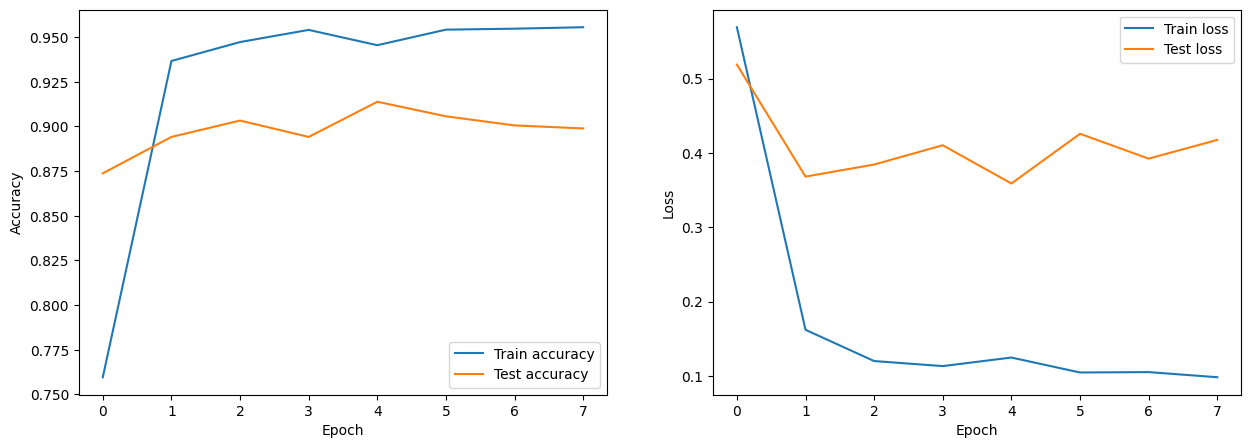

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(cae_output.history['accuracy'], label='accuracy')
plt.plot(cae_output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(cae_output.history['loss'], label='loss')
plt.plot(cae_output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Test loss'], loc='upper right')

In [29]:
import numpy as np
def recogniseActivity(l):
  labelIndex = np.argmax(l)
  l[:]=0
  for i in range(6):
    if i==labelIndex:
      l[i]=1
  return l

testList = [0,7,16,29,36,42,50,65,73,86,94,100,151,628,757,921,1000,1311,1954,2231,2569,2946]
for i in testList:
  y_pred = recogniseActivity(cae_model.predict(np.expand_dims(testX[i], axis=0))[0])
  print(y_pred,testy[i])

1/1 [==============================] - 0s 172ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 28ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 27ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 22ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 22ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 25ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 27ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 

In [30]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from keras.utils import to_categorical

y_pred = cae_model.predict(testX)
pred_labels = to_categorical(np.argmax(y_pred, axis=1))
cae_acc = accuracy_score(testy,pred_labels)
print(cae_acc)
print(precision_score(testy,pred_labels,average='weighted'))
print(recall_score(testy,pred_labels,average='weighted'))


93/93 [==============================] - 1s 13ms/step
0.8988802171700034
0.9042040784018107
0.8988802171700034


93/93 [==============================] - 1s 9ms/step


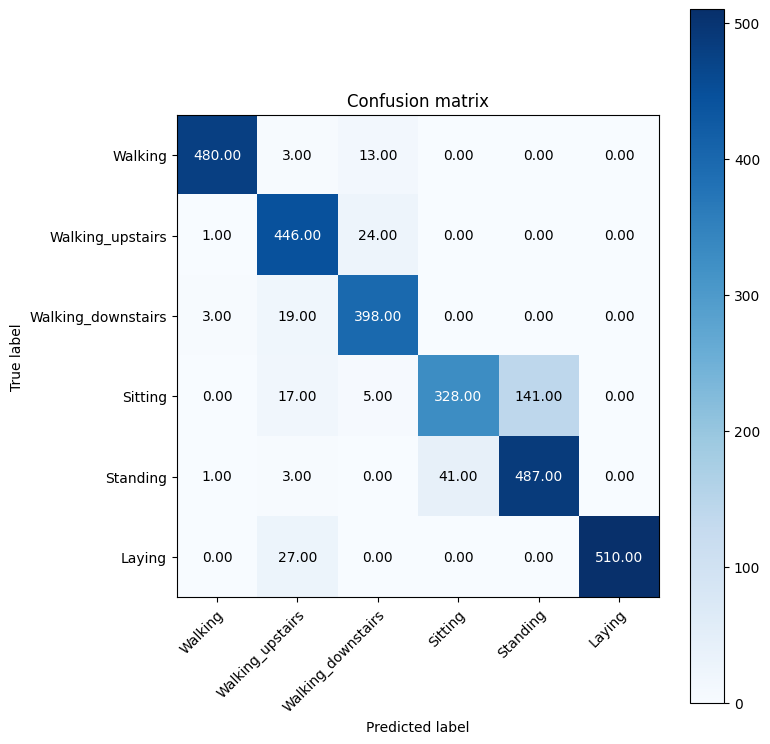

In [31]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix

cm = confusion_matrix(np.argmax(testy, axis=1), np.argmax(to_categorical(np.argmax(cae_model.predict(testX), axis=1)),axis=1))

# Define class names (6 classes)
class_names = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f'  # set format for decimal places
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [32]:
import time
start_time_testing = time.time()
cae_model.evaluate(testX, testy)
end_time_testing = time.time()
cae_time = end_time_testing-start_time_testing

93/93 [==============================] - 1s 9ms/step - loss: 0.4174 - accuracy: 0.8989


ConvAE-LSTM

In [33]:
from keras.optimizers import Adam

caelstm_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=(128, 9)),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
   
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((64, -1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])


caelstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
caelstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 64, 32)            6176      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 32, 32)            3104      
                                                                 
 up_sampling1d_2 (UpSampling  (None, 64, 32)          

In [35]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)

caelstm_output = caelstm_model.fit(
  x=trainX, 
  y=trainy, 
  epochs=20,
  batch_size = 128,
  validation_data = (testX,testy),
  callbacks = [early_stop]
)

Epoch 1/20
58/58 [==============================] - 17s 289ms/step - loss: 0.0995 - accuracy: 0.9584 - val_loss: 0.3478 - val_accuracy: 0.9084
Epoch 2/20
58/58 [==============================] - 16s 273ms/step - loss: 0.1020 - accuracy: 0.9581 - val_loss: 0.3620 - val_accuracy: 0.9080
Epoch 3/20
58/58 [==============================] - 16s 278ms/step - loss: 0.0955 - accuracy: 0.9603 - val_loss: 0.3565 - val_accuracy: 0.9121
Epoch 4/20
58/58 [==============================] - 16s 270ms/step - loss: 0.1049 - accuracy: 0.9596 - val_loss: 0.3822 - val_accuracy: 0.9097
Epoch 5/20
58/58 [==============================] - 16s 274ms/step - loss: 0.1017 - accuracy: 0.9612 - val_loss: 0.4113 - val_accuracy: 0.9084
Epoch 6/20
58/58 [==============================] - 17s 299ms/step - loss: 0.0970 - accuracy: 0.9623 - val_loss: 0.4006 - val_accuracy: 0.9063
Epoch 6: early stopping


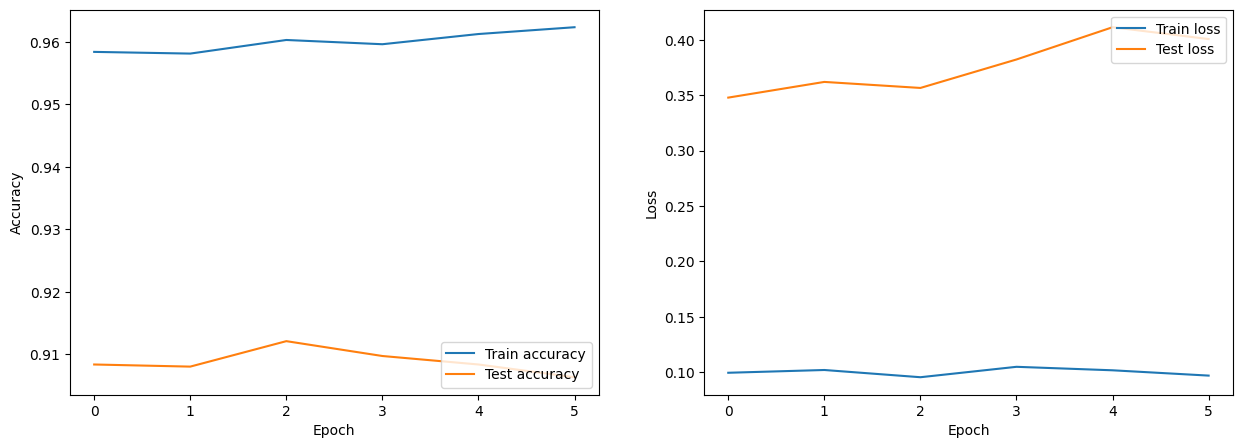

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(caelstm_output.history['accuracy'], label='accuracy')
plt.plot(caelstm_output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(caelstm_output.history['loss'], label='loss')
plt.plot(caelstm_output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Test loss'], loc='upper right')

In [37]:
import numpy as np
def recogniseActivity(l):
  labelIndex = np.argmax(l)
  l[:]=0
  for i in range(6):
    if i==labelIndex:
      l[i]=1
  return l

testList = [0,7,16,29,36,42,50,65,73,86,94,100,151,628,757,921,1000,1311,1954,2231,2569,2946]
for i in testList:
  y_pred = recogniseActivity(caelstm_model.predict(np.expand_dims(testX[i], axis=0))[0])
  print(y_pred,testy[i])

1/1 [==============================] - 1s 576ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 28ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 31ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 27ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 27ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 28ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 28ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 28ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 

In [38]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from keras.utils import to_categorical

y_pred = caelstm_model.predict(testX)
pred_labels = to_categorical(np.argmax(y_pred, axis=1))
caelstm_acc = accuracy_score(testy,pred_labels)
print(caelstm_acc)
print(precision_score(testy,pred_labels,average='weighted'))
print(recall_score(testy,pred_labels,average='weighted'))


93/93 [==============================] - 2s 20ms/step
0.9063454360366474
0.906808931011197
0.9063454360366474


93/93 [==============================] - 2s 20ms/step


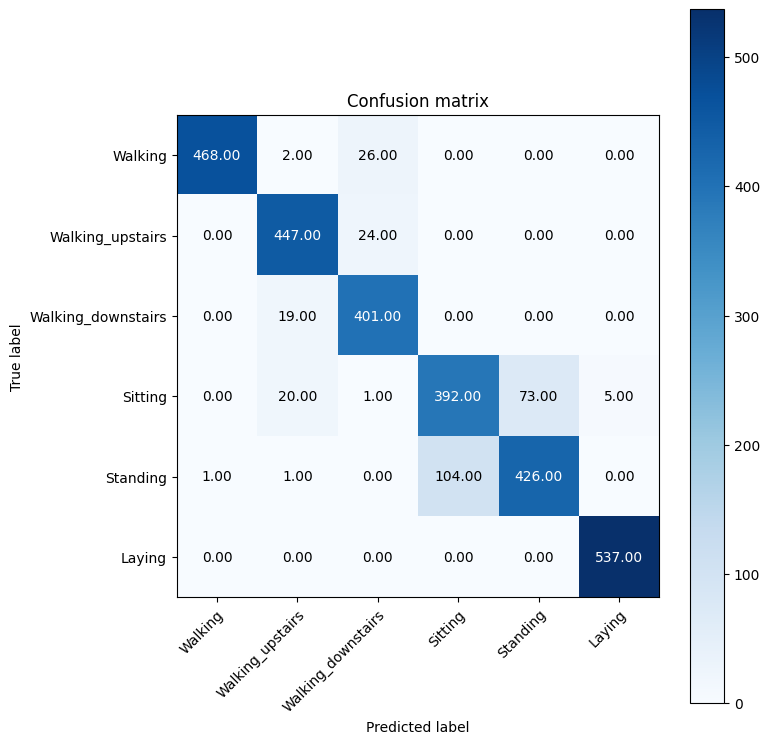

In [39]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix

cm = confusion_matrix(np.argmax(testy, axis=1), np.argmax(to_categorical(np.argmax(caelstm_model.predict(testX), axis=1)),axis=1))

# Define class names (6 classes)
class_names = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f'  # set format for decimal places
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [40]:
import time
start_time_testing = time.time()
caelstm_model.evaluate(testX, testy)
end_time_testing = time.time()
caelstm_time = end_time_testing-start_time_testing

93/93 [==============================] - 2s 21ms/step - loss: 0.4006 - accuracy: 0.9063


### **Comparision**

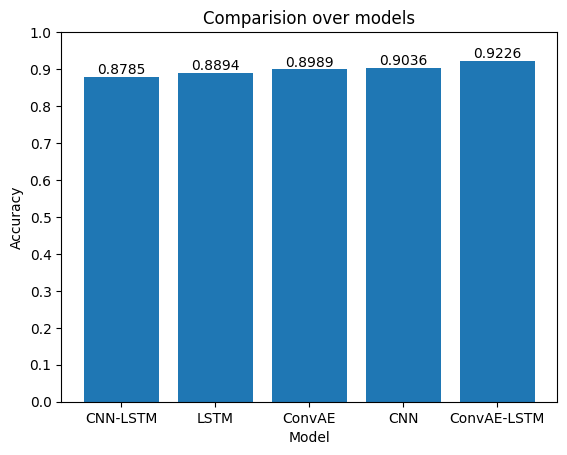

In [49]:
import matplotlib.pyplot as plt

# Define the data
x = ['CNN', 'LSTM' , 'CNN-LSTM' , 'ConvAE' , 'ConvAE-LSTM']  # Labels for the bars
y = [cnn_acc,lstm_acc,cnnlstm_acc,cae_acc,caelstm_acc]      # Heights of the bars

# Create the bar chart
sorted_data = sorted(zip(y, x))

# Extract the sorted x and y values
x_sorted = [val[1] for val in sorted_data]
y_sorted = [val[0] for val in sorted_data]

# Plot the sorted data
fig, ax = plt.subplots()
ax.bar(x_sorted, y_sorted)
for i in range(len(x_sorted)):
    plt.text(i, y_sorted[i], "{:.4f}".format(y_sorted[i]), ha='center', va='bottom')
# Set y-axis limits to 0.1
ax.set_ylim([0, 1])

# Set y-axis tick labels
yticklabels = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels(yticklabels)

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparision over models')

# Show the chart
plt.show()

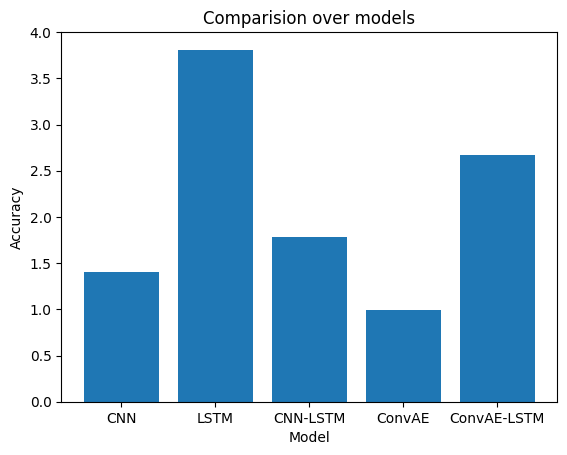

In [51]:
import matplotlib.pyplot as plt

# Define the data
x = ['CNN', 'LSTM' , 'CNN-LSTM' , 'ConvAE' , 'ConvAE-LSTM']  # Labels for the bars
y = [cnn_time,lstm_time,cnnlstm_time,cae_time,caelstm_time]      # Heights of the bars

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(x, y)
# Set y-axis limits to 0.1
# ax.set_ylim([0, 0.6])

# Set y-axis tick labels
# yticklabels = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']
# ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
# ax.set_yticklabels(yticklabels)

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparision over models')

# Show the chart
plt.show()